In [158]:
!zip -r figures.zip ./results/figures

updating: results/figures/ (stored 0%)
  adding: results/figures/best_xgb_heatmap_dist.png (deflated 0%)
  adding: results/figures/LinearDiscriminantAnalysis_ROC.png (deflated 10%)
  adding: results/figures/LinearDiscriminantAnalysis_waterfall_idx1.png (deflated 12%)
  adding: results/figures/LogisticRegression_beeswarm.png (deflated 12%)
  adding: results/figures/.ipynb_checkpoints/ (stored 0%)
  adding: results/figures/.ipynb_checkpoints/best_xgb_waterfall_idx1-checkpoint.png (deflated 12%)
  adding: results/figures/.ipynb_checkpoints/LogisticRegression_waterfall_idx1-checkpoint.png (deflated 13%)
  adding: results/figures/.ipynb_checkpoints/all_ROC-checkpoint.png (deflated 7%)
  adding: results/figures/XGBClassifier_ROC.png (deflated 11%)
  adding: results/figures/all_ROC.png (deflated 7%)
  adding: results/figures/RandomForestClassifier_feature_importance.png (deflated 28%)
  adding: results/figures/XGBClassifier_beeswarm.png (deflated 3%)
  adding: results/figures/best_xgb_beeswar

In [11]:
seed = 0

import os
import sys

utils_path = os.path.abspath("./utilities/")
sys.path.append(utils_path)

from load_data import load_fullECAI
from evaluation import *
from evaluation import _my_scorer

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, euclidean_distances

import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
palette = cc.b_glasbey_category10

import joblib
from joblib import Parallel, delayed

from igraph import Graph
import igraph as ig


In [12]:
import shap

shap.plots._labels.labels['FEATURE_VALUE_LOW'] = 'Bajo'
shap.plots._labels.labels['FEATURE_VALUE_HIGH'] = 'Alto'
shap.plots._labels.labels['FEATURE_VALUE'] = 'Valor SHAP'

In [13]:
### LOAD DATA ###
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [ ]:
# ###### RECOVER BEST XGB and save it in a standard form

# from sklearn.metrics import f1_score, confusion_matrix

# grid = joblib.load('./results/XGBoost/GridSearchCV_22-03-22_03-27-03/GridSearchCV_22-03-22_03-27-03.pkl')
# model = grid.best_estimator_
# clf = model
# X_val = X_test

# y_pred_val = clf.predict(X_val)
# y_prob_val = clf.predict_proba(X_val)
    
# cf = confusion_matrix(y_test, y_pred_val)
# f1 = f1_score(y_test, y_pred_val)

# explainer = shap.Explainer(model)
# shap_test = explainer(X_val)

# path = './results/XGBoost/GridSearchCV_22-03-22_03-27-03/models/best/best_xgb.pkl'
# save_model(path, model.get_params(), shap_test, X_val, y_pred_val, y_prob_val, cf, f1)

In [199]:
def save_plot(model_path, fig_str):
    if not os.path.exists('results/figures'):
        os.makedirs('results/figures')
    
    model_name = model_path.split('/')[-1].split('.')[0]
    fig_name = 'results/figures/{}_{}'.format(model_name, fig_str)
    results = plt.savefig(fig_name+'.png', bbox_inches='tight', dpi=300, transparent=True)
    results = plt.savefig(fig_name+'.svg', bbox_inches='tight', transparent=True)

    
def ROC(model_info, model_path, ax=None):
    if ax == None:
        ax = plt.gca()
        
    y_proba_1 = model_info['y_proba'][:,1]
    
    fig, ax = plt.subplots()
    RocCurveDisplay.from_predictions(y_test, y_proba_1, ax=ax)
    
    
def all_ROC(models_paths):
    """
    Plots ROC curves for models passed in same figure
    """
    fig, ax = plt.subplots()
    for i, model_path in enumerate(models_paths):
        model_name = model_path.split('/')[-1].split('.')[0]
        model_info = joblib.load(model_path)
        y_proba_1 = model_info['y_proba'][:,1]

        RocCurveDisplay.from_predictions(y_test, y_proba_1, ax=ax, color=palette[i], label=model_name)

    ax.set_xlabel('Prop. de falsos postitivos')
    ax.set_ylabel('Prop. de verdaderos postitivos')
    ax.legend(labels=['XGBB', 'GIU','RF', 'LR', 'LDA', 'XGB'])
    save_plot('/all.', 'ROC')
    plt.show()


def shap_bee(model_info, model_path):
    shap_test = model_info['shap_test']
    
    shap.plots.beeswarm(shap_test, max_display=11, show=False, color_bar_label='Valor SHAP')
    # Modify
    #plt.xlabel('Valor SHAP (Impacto en la salida del modelo)')
    plt.xlabel('')
    locs, labels = plt.yticks()
    labels[0].set_text('Suma del resto')
    plt.yticks(locs, labels)
    
    f = plt.gcf()
    ax1, ax2 = f.get_axes()
    ax2.set_aspect(100)
    ax2.set_box_aspect(100)
    
    # Save and show
    save_plot(model_path, 'beeswarm')
    plt.show()
    
    
def shap_feat_importance(model_info, model_path):
    shap_test = model_info['shap_test']
    shap.summary_plot(shap_test, plot_type='bar', show=False, feature_names=model_info['shap_df'].columns)
    plt.xlabel('')
    #plt.xlabel('media(|valor SHAP|) (impacto promedio en la maginitud de la predicción del modelo)')
    
    save_plot(model_path, 'feature_importance')
    plt.show()

    
def shap_waterfall(model_info, model_path, idx):
    shap_df = model_info['shap_df']
    shap_test = model_info['shap_test']
    sample_idx = shap_df.index[idx]
    
    shap.plots.waterfall(shap_test[idx], max_display=10, show=False)
    # Modify plot
    f = plt.gcf()
    f.set_size_inches(8, 6)
    a,b,c = f.get_axes()
    labels = a.get_ymajorticklabels()
    labels[0].set_text('10 variables más')
    labels[10].set_text('10 variables más')
    a.set_yticklabels(labels)

    a.set_xlabel('Log-Odds', fontsize=12)
    a.get_xaxis().set_ticks([])
    
    # Save and show
    save_plot(model_path, 'waterfall_idx{}'.format(idx))
    plt.show()
    
def normalize(shap_dist, log_trans=False):
    n = shap_dist.shape[0]
    
    if log_trans:
        shap_dist = np.log(shap_dist)
        shap_dist[shap_dist == -np.inf] = np.nan #MinMaxScaler ignores nan values
        
    mm = MinMaxScaler()
    mm.fit(shap_dist.flatten().reshape(-1, 1))
    shap_dist = mm.transform(shap_dist.flatten().reshape(-1, 1)).reshape(n, n)
    normalized_dist = np.nan_to_num(shap_dist, 0) #Fill diagonal with original zeros
    
    return normalized_dist

def heatmap(model_info, model_path, transform='norm'):
    model_name = model_path.split('/')[-1].split('.')[0]
    
    n = 1000
    y_testc = y_test.copy()
    shap_df, _, y_testc, _ = train_test_split(model_info['shap_df'], y_testc, train_size=n)
    shap_dist = euclidean_distances(shap_df)
    
    if transform=='norm':
        shap_dist = normalize(shap_dist, log_trans=False)

    elif transform=='log':
        shap_dist = normalize(shap_dist, log_trans=True)

    elif transform=='none':
        pass

    ax = sns.heatmap(shap_dist[np.argsort(y_testc).values][:,np.argsort(y_testc).values], xticklabels=False, yticklabels=False)
    ax = ax.invert_yaxis()
    
    save_plot(model_path, 'heatmap_dist_{}'.format(transform))
    plt.show()
    
    
def compare():
    sns.boxplot(x="variable", y="value", data=pd.melt(results))
    plt.ylabel('Macro valor F1')
    plt.xlabel('Modelo')
    
    if not os.path.exists('results/figures'):
        os.makedirs('results/figures')
    plt.savefig('results/figures/mb_F1_CV.png', bbox_inches='tight', dpi=300, transparent=True)

In [15]:
models_paths = ['./results/XGBoost/GridSearchCV_22-03-22_03-27-03/models/best/best_xgb.pkl',
                './results/GiudiciXGB.pkl',
                './results/Basic/models/RandomForestClassifier.pkl', 
                './results/Basic/models/LogisticRegression.pkl',
                './results/Basic/models/LinearDiscriminantAnalysis.pkl',
                './results/Basic/models/XGBClassifier.pkl']

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


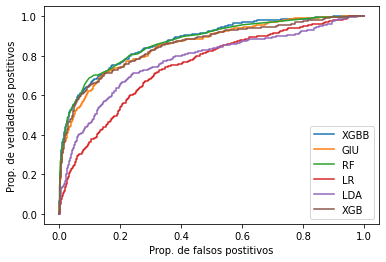

In [9]:
all_ROC(models_paths)

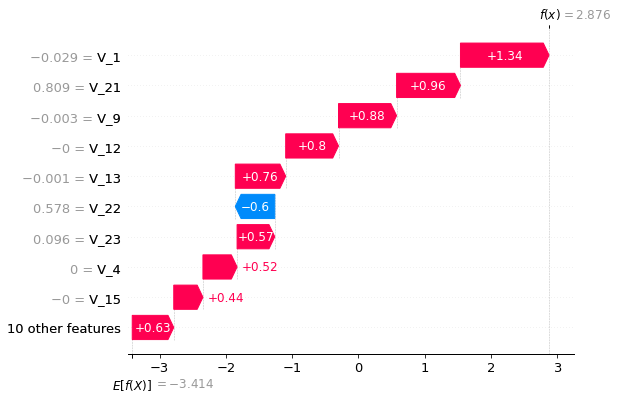

In [159]:
shap_df = model_info['shap_df']
shap_test = model_info['shap_test']

sample_idx = shap_df.index[666]
shap.plots.waterfall(shap_test[666], max_display=10, show=False)
f = plt.gcf()

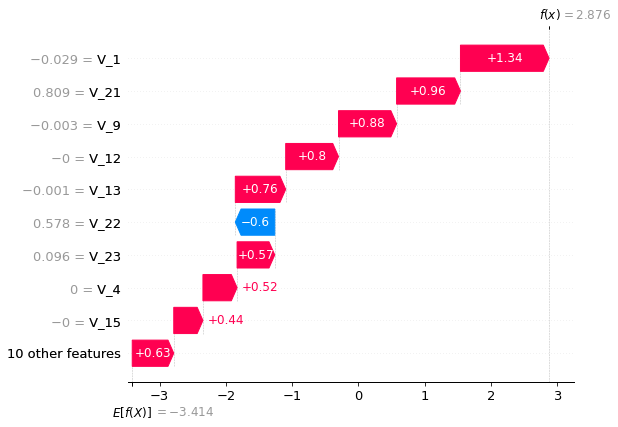

In [160]:
shap_df = model_info['shap_df']
shap_test = model_info['shap_test']

sample_idx = shap_df.index[666]
shap.plots.waterfall(shap_test[666], max_display=10, show=False)
f = plt.gcf()
f.set_size_inches(8, 6.5)

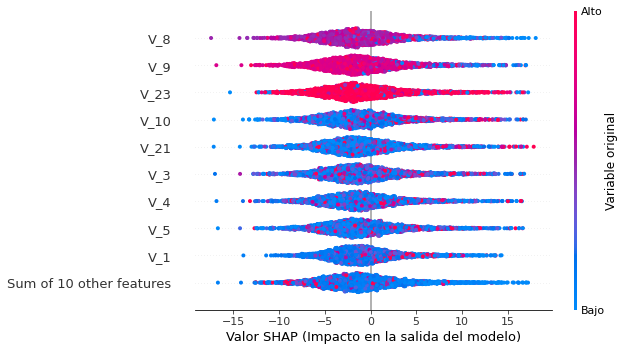

In [268]:
shap_test = model_info['shap_test']

shap.plots.beeswarm(shap_test, max_display=10, show=False, color_bar_label='Variable original')
# Modify
plt.xlabel('Valor SHAP (Impacto en la salida del modelo)')
f = plt.gcf()
ax1, ax2 = f.get_axes()
ax2.set_aspect(100)
ax2.set_box_aspect(100)
#extent = ax2.get_window_extent().transformed(f.dpi_scale_trans.inverted())
extent = full_extent(ax2, pad=0.0).transformed(f.dpi_scale_trans.inverted())

f.savefig('results/figures/colorbar_shap.svg', bbox_inches=extent, transparent=True)

In [264]:
from matplotlib.transforms import Bbox

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    items += [ax.get_xaxis().get_label(), ax.get_yaxis().get_label()]
    
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

In [257]:
extent.expanded(4, 1)

Bbox([[4.875000000000002, 0.6875000000000006], [8.595, 4.84]])

## Beeswarm e importancia de variables

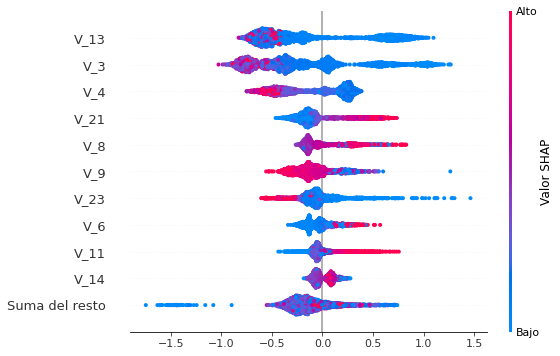

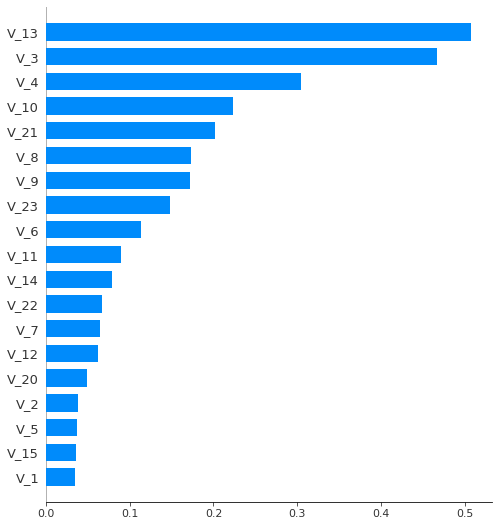

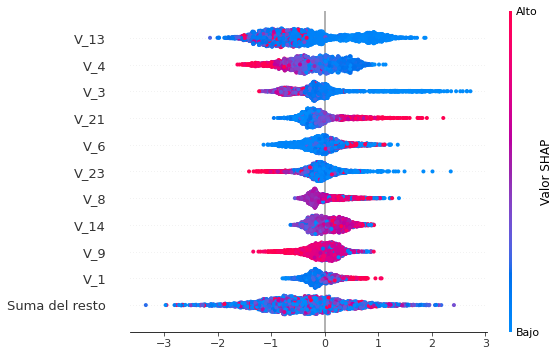

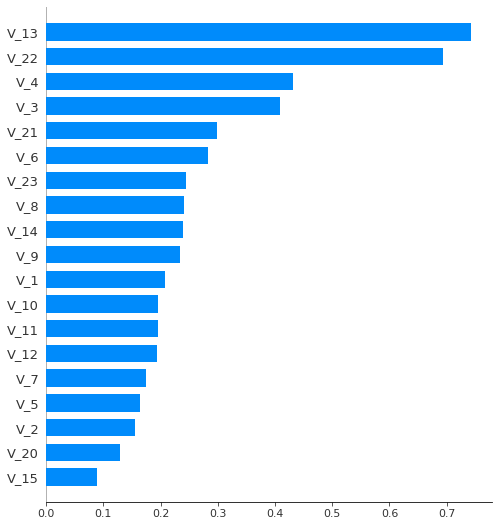

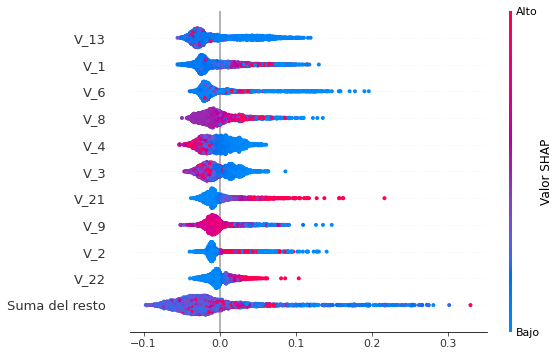

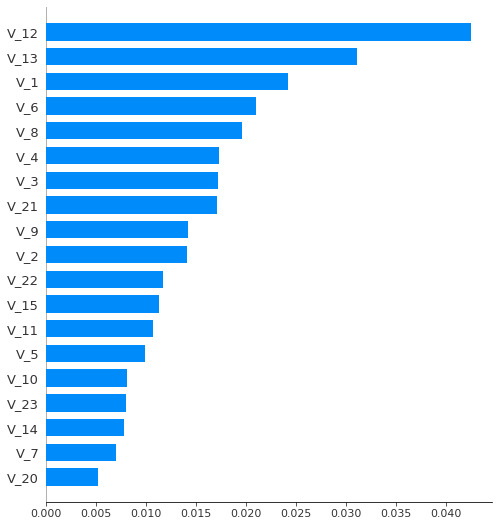

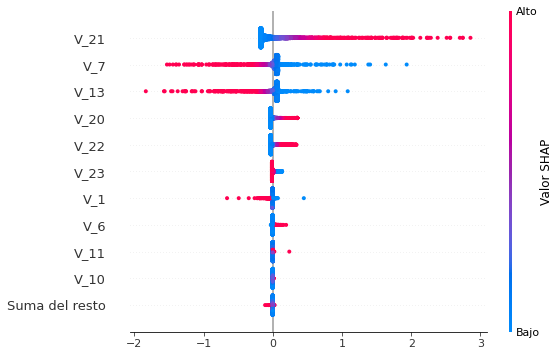

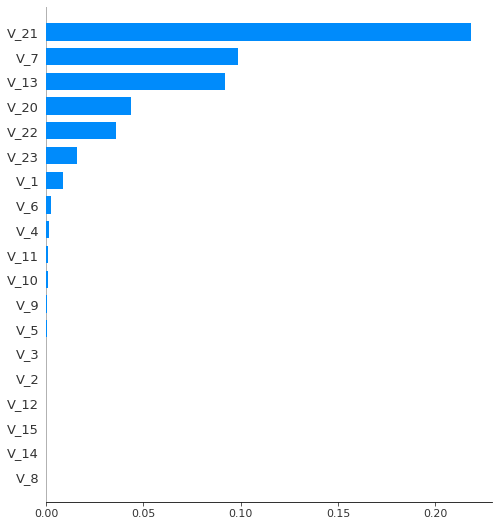

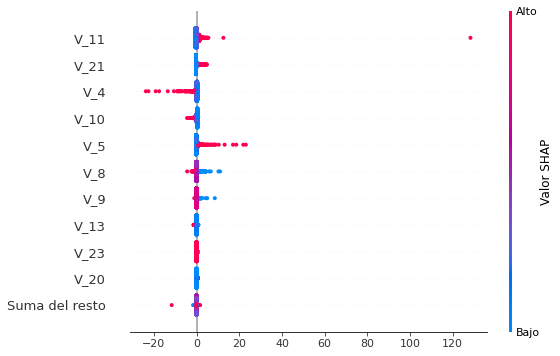

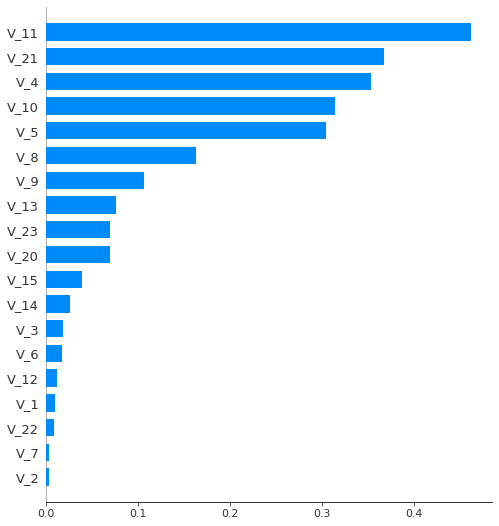

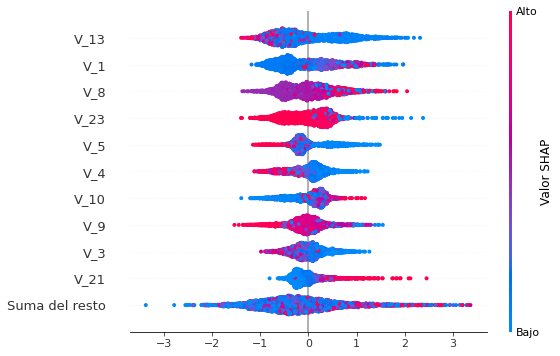

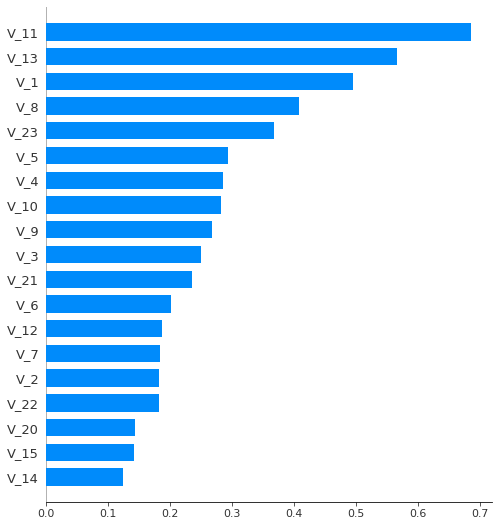

In [29]:
# Get single plots for each model
y_preds = []
for model_path in models_paths:
    model_info = joblib.load(model_path)
    shap_bee(model_info, model_path)
    shap_feat_importance(model_info, model_path)
    #heatmap(model_info, model_path)
    
    # Recover predicitions for later
    y_preds.append(model_info['y_pred'])

## Waterfall

In [ ]:
predicted_correctly = np.array([(y_pred == y_test) & (y_test==0) for y_pred in y_preds]).T
all_correct = np.all(predicted_correctly, axis=1)
one_all_correct_idx = np.where(all_correct == True)[0][0]

for model_path in models_paths:
    model_info = joblib.load(model_path)
    shap_waterfall(model_info, model_path, one_all_correct_idx)

## Heatmap

In [52]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
for model_path in models_paths:
    model_info = joblib.load(model_path)
    heatmap(model_info, model_path, transform='none')
    heatmap(model_info, model_path, transform='norm')
    heatmap(model_info, model_path, transform='log')

### Test graph plots

In [162]:
import igraph as ig

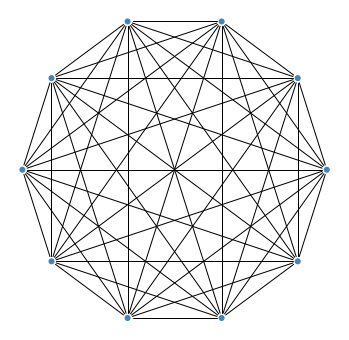

In [192]:
size = 10
A = np.ones((size,size))
np.fill_diagonal(A,0)
g = ig.Graph.Adjacency(A, mode='undirected', loops=False)

fig, ax = plt.subplots(figsize=(6,6))
layout = g.layout_circle()
ig.plot(g, layout=layout, target=ax)
ax.axis('off')
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)

plt.savefig('results/figures/fully_graph.svg', bbox_inches='tight', dpi=600, transparent=True)